## Chargement du dataset

In [43]:
import csv
import pandas as pd

file_path_train = "../data/train_submission_1.csv"
file_path_test = "../data/test_without_labels_1.csv"

data_train = pd.read_csv(file_path_train)


## Analyse du dataset d'entraînement

### On observe d'abord les données non labellisées

In [44]:
data_train_without_label = data_train[data_train["Label"].isna()]

In [45]:
data_train_without_label

,Usage,Text,Label
107,Public,Kòe bô jōa kú hō͘-sū sió-chiá lâi kā góan mn̄...,NaN
803,Public,Söğütçük sī chi̍t ê tī Türkiye Aydın séng Çine...,NaN
1095,Public,Golden Valley Kūn ū khó-lêng sī kóng:,NaN
1894,Public,Tī Montégut-Lauragais ê sì-ûi ū Nogaret Revel...,NaN
2499,Public,Soveria Simeri ùi séng lāi ê hoān-ûi.,NaN
...,...,...,...
189637,Public,Bellebrune sī ūi-tī Hoat-kok Nord-Pas-de-Calai...,NaN
189946,Public,Bô phah-sǹg tī sin-le̍k 10 go̍eh 29 hō ē-po͘ ...,NaN
189959,Public,Wiejki sī chi̍t ê tī Pho-lân Kiōng-hô-kok Podl...,NaN
190397,Public,Tī pún só͘-chāi sì-ûi ê tē-hng ū Valy Veselí ...,NaN


Il y a 500 instances qui ne sont pas labellisées. 

On choisit de se débarasser de ces données pour l'entraînement de nos modèles.

In [46]:
data_train_without_nan_for_label = data_train.dropna() # suppression des données non labellisées

### Analyse des données labellisées

In [5]:
number_of_languages = len(data_train["Label"].unique())
print(f"Il y a {number_of_languages} différentes langues dans le dataset de train")

Il y a 390 différentes langues dans le dataset de train


In [50]:
dataset_sorted_by_number_instances_by_language = data_train_without_nan_for_label.groupby("Label").count().sort_values('Usage', ascending=True)
dataset_sorted_by_number_instances_by_language.head()

,Usage,Text
Label,,
gcr,1,1
gaa,1,1
toi,1,1
kua,1,1
gil,2,2


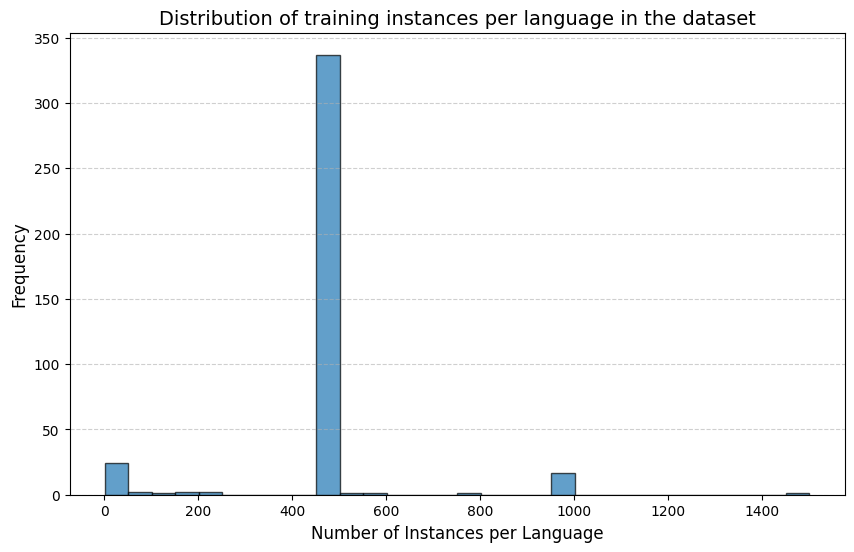

In [7]:
import matplotlib.pyplot as plt
# Creating an histogram
plt.figure(figsize=(10, 6))
plt.hist(dataset_sorted_by_number_instances_by_language['Text'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Number of Instances per Language", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of training instances per language in the dataset", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

In [55]:
#Underrepresented languages
df = dataset_sorted_by_number_instances_by_language
underrepresented_languages = list(df[df['Text']<10].index)

['gcr',
 'gaa',
 'toi',
 'kua',
 'gil',
 'tvl',
 'pau',
 'crs',
 'wbm',
 'niu',
 'miq',
 'ada',
 'teo',
 'quz',
 'ngl']

On observer que le nombre d'exemples par langue varie. Certaines langues sont sur-représentées (avec 1500 instances pour la première) par rapport à d'autres. 

In [9]:
percentage_of_languages_with_at_least_100_instances = len(dataset_sorted_by_number_instances_by_language[dataset_sorted_by_number_instances_by_language["Usage"] >= 100])/len(dataset_sorted_by_number_instances_by_language) * 100
print(f"Le pourcentage de langues avec au moins 100 instances est {percentage_of_languages_with_at_least_100_instances}%")

Le pourcentage de langues avec au moins 100 instances est 93.31619537275064%


## Pré-traitement du dataset de train

In [7]:
import string
import re 
import unicodedata

def cleaning(text): 
    """
    Fonction pour pré-traiter le texte en enlevant tous les éléments de ponctuation, les chiffres, les double espaces, les URL etc. 
    """

    if not isinstance(text, str):
        return ""

    # text = re.sub(r"\(.*?\)|\[.*?\]|\{.*?\}|['\"«»„“”‘’]|\<.*?\>", " ", text) # 1. Supprimer les textes entre (), [], {}, "", « »
    text = re.sub(r"https?://[^\s]+|www\.[^\s]+", " ", text) # Supprimer les URLs
    # text = re.sub(r"\b[A-ZÀ-ÖØ-Þ][a-zà-öø-ÿ]*", " ", text) # Supprimer les mots qui commencent par une majuscule (prénoms, noms propres, etc.)
    # text = re.sub(r"\b[A-Z]+\d*[A-Z\d]*", " ", text) # Supprimer les sigles type "IK10", "ABC123", "X4D" (au moins 1 lettre + au moins 1 chiffre)
    text = re.sub(r"\d+", " ", text)  # Supprimer les nombres isolés
    text = text.translate(str.maketrans("", "", string.punctuation))  # Supprimer la ponctuation et les caractères spéciaux
    # text = ''.join(c for c in text if unicodedata.category(c)[0] not in ["C", "S"])  # Supprimer les caractères de contrôle Unicode, symboles et emojis
    text = ''.join(c for c in text if not (unicodedata.category(c).startswith('P') or unicodedata.category(c) in ['No']))

    asian_punctuation = "，。？！《》【】（）；：、。•" # Liste de ponctuation à inclure pour les langues asiatiques
    text = re.sub(r'[\-\u2010-\u2015]', '', text) # supprime tous les types de tirets
    text = re.sub(r"['\"‘’‚‛“”„‟‹›«»⹂⹃⸂⸃⸄⸅⸉⸊「」『』〝〞＂ˮ`´ʹʺʻʼʽʾʿˈˊˋ]", '', text)

    # text = text.translate(str.maketrans('', '', string.punctuation + asian_punctuation)) # supprime la ponctuation asiatique
    text = re.sub(r"\s+", " ", text).strip() # enlève les double espaces

    text_cleaned = text.lower() # met le texte en minuscule 

    return(text_cleaned)


On choisit de ne pas enlever le texte entre (), [], {}, "", « » car on s'aperçoit que les résultats sont moins bons, cela nous fait perdre de l'information utile. 

### Création d'un ensemble de mots anglais pour pouvoir enlever les mots anglais dans les phrases avec des mots anglais mélangés à d'autres langues

In [10]:
import nltk
from nltk.corpus import words

# Télécharger la liste des mots en anglais (une seule fois nécessaire)
nltk.download('words')

# Liste des mots en anglais
english_words = set(word.lower() for word in words.words())


[nltk_data] Downloading package words to
[nltk_data]     /Users/hippolytelecomte/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [11]:
data_ang = data_train_without_nan_for_label[data_train_without_nan_for_label["Label"] == 'eng']["Text"]

# Collecte des mots uniques
for text in data_ang:
    for word in text.split():
        english_words.add(word.lower())

In [12]:
def remove_most_english_words(text): 
    """
    Fonction pour enlever les mots anglais lorsque la langue du texte n'est pas l'anglais. 
    """
    tokens = text.split() 
    filtered_tokens = [word for word in tokens if word.lower() not in english_words]

    return ' '.join(filtered_tokens)

Finalement on s'aperçoit qu'enlever les mots anglais dans les phrases qui ne sont pas labellisées comme du texte anglais baisse nos résultats. 

In [8]:
from tqdm import tqdm
tqdm.pandas()  

def pre_processing(df, remove_espace = True, not_test = True, need_to_clean = True): 
    """
    Utilisation des méthodes de pré-traitement définies auparavant pour rendre le texte propre. 
    """

    if need_to_clean: 
        df['Text'] = df['Text'].apply(cleaning)
    
    if not_test: 
        df['Text'] = df.progress_apply(
            lambda row: remove_most_english_words(row['Text']) if row['Label'] != 'eng' else row['Text'], axis=1
        )
    
    if remove_espace: 
        df['Text'] = df['Text'].str.replace(' ', '', regex=False)
    
    return df


On s'apperçoit également que dans le dataset d'entraînement il y a des langues qui peuvent écrites dans différents alphabets, c'est le cas pour certaines langues asiatiques notamment. On choisit ainsi de créer une fonction qui permet de détecter les alphabets présents dans la phrase et de déterminer l'alphabet majoritaire en fonction du nombre de caractères (même si cette méthode n'est pas optimale car certains alphabets contiennent plus d'informations dans leur caractère que d'autres). Ensuite on change le label des phrases en ajoutant l'alphabet utilisé pour la langue et créant ainsi de nouvelles catégories comme fra_Latin pour le français écrit avec l'alphabet latin. 

In [9]:
import unicodedata
from collections import defaultdict

# Catégorisation fine des scripts
SCRIPT_MAP = {
    "LATIN": "Latin",
    "CYRILLIC": "Cyrillique",
    "ARABIC": "Arabe",
    "HEBREW": "Hébreu",
    "GREEK": "Grec",
    "DEVANAGARI": "Devanagari (Hindi, Sanskrit)",
    "HIRAGANA": "Hiragana (Japonais)",
    "KATAKANA": "Katakana (Japonais)",
    "CJK": "Kanji (Chinois, Japonais, Coréen)",
    "HANGUL": "Hangul (Coréen)",
    "THAI": "Thaï",
    "ARMENIAN": "Arménien",
    "GEORGIAN": "Géorgien",
    "ETHIOPIC": "Éthiopien",
    "TAMIL": "Tamoul",
    "BENGALI": "Bengali",
    "TELUGU": "Télougou",
}

def count_alphabet_characters(text):
    script_counts = defaultdict(int)

    for char in text:
        if char.isalpha():  # On ignore les symboles et ponctuations
            try:
                char_name = unicodedata.name(char) 
                script_key = char_name.split()[0]  # Prend le premier mot du nom Unicode
                
                if "CJK" in char_name:
                    script_key = "CJK"  # Les kanji sont classés sous "CJK UNIFIED IDEOGRAPH"
                
                script_name = SCRIPT_MAP.get(script_key, script_key)  # Utilise le mapping o
                script_counts[script_name] += 1  # Incrémente le compteur
                
            except ValueError:
                continue  # Si le caractère n'a pas de nom Unicode
    
    return dict(script_counts)  # Retourne un dictionnaire des comptages

def most_frequent_script(text):
    script_counts = count_alphabet_characters(text)  # Appel de la fonction précédente
    
    if script_counts:  # Vérifie si le dictionnaire n'est pas vide
        most_common_script = max(script_counts.items(), key=lambda x: x[1])  # Trouve l'alphabet avec le max de caractères
        return most_common_script  # Retourne (nom de l'alphabet, nombre d'occurrences)
    else:
        return None  # Retourne None si aucun alphabet trouvé

from tqdm import tqdm

def add_alphabet_to_label(df):
    for index, row in tqdm(df.iterrows(), total=len(df)):  # Parcourt chaque ligne du DataFrame
        alphabet_most_frequent = most_frequent_script(row['Text'])  # Détecte l'alphabet dominant
        
        if alphabet_most_frequent:  # Vérifie si un alphabet a été trouvé
            df.at[index, 'Label'] = f"{row['Label']}_{alphabet_most_frequent[0]}"  # Met à jour le label
    
    return df


In [ ]:
import numpy as np 

def restore_original_label(label):
    return label.split("_")[0]  # Prend seulement la première partie avant '_'

def restore_labels(liste):
    new_liste = []
    for element in tqdm(liste): 
        new_liste.append(restore_original_label(element))
    return np.array(new_liste)

## Première approche sans tokenizer avec TFIDF et MultinomialNB

In [ ]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(data_train_without_nan_for_label, test_size=0.1, random_state=42)

Application du pré-traitement et du changement de labellisation sur le train et le val. 

In [18]:
train_set_first_version = train_set.copy()
val_set_first_version = val_set.copy()
train_set_first_version = pre_processing(train_set_first_version, remove_espace=False, not_test=False) 
val_set_first_version = pre_processing(val_set_first_version, remove_espace=False, not_test=False)
train_set_first_version = add_alphabet_to_label(train_set_first_version)
val_set_first_version = add_alphabet_to_label(val_set_first_version)

100%|██████████| 19010/19010 [00:00<00:00, 25265.55it/s]


Mise en place de la pipeline pour le modèle où on choisit d'utiliser comme Vectorizer TFIDF et comme modèle MultinomialNB.

In [19]:
val_set_first_version.head(5)

,Usage,Text,Label
128184,Public,apărând din față întrun exercițiu apăsând rolu...,ron_Latin
95049,Public,sa kaya vua ko jisu sa volai talega mo kakua n...,fij_Latin
170377,Public,אין צוואנציק יאר האט דאס דארף פארוואנדלט אין א...,yid_Hébreu
171119,Public,seniň sözüňe gulak assa bu doganyňy gazandygyň...,tuk_Latin
62238,Public,ala sma fu grontapu o kon na en fesi dan a o p...,srn_Latin


In [20]:
x_train = train_set_first_version['Text'].tolist()
y_train = train_set_first_version['Label'].tolist()
x_val = val_set_first_version['Text'].tolist()
y_val = val_set_first_version['Label'].tolist()
y_total = y_train + y_val

# converting categorical variables to numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_val = le.transform(y_val)
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [32]:
# Utilisation dans le pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB


# Pipeline avec barres de progression
pipe = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer="char", ngram_range=(1, 5), max_features=200000)),
    ('classifier', MultinomialNB(alpha=0.001, fit_prior=False))
])


# Utilisation
pipe.fit(x_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_features=200000,
                                 ngram_range=(1, 5))),
                ('classifier', MultinomialNB(alpha=0.001, fit_prior=False))])

In [41]:
from sklearn.metrics import accuracy_score, classification_report

predictions = pipe.predict(x_val)
accuracy = accuracy_score(y_val, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8514466070489216


Création de fonctions pour récupéer les labels originaux. 

In [58]:
predicted_labels = le.inverse_transform(predictions)
labels_predict = le.inverse_transform(y_val)

In [59]:
final_pred = restore_labels(predicted_labels)
val_predict = restore_labels(labels_predict)
final_accuracy = accuracy_score(val_predict, final_pred)
print("Accuracy:", final_accuracy)

100%|██████████| 19010/19010 [00:00<00:00, 476642.55it/s]

Accuracy: 0.7778011572856391


### Analyse des résultats

In [52]:
import numpy as np

# Obtenir les indices des classes présentes dans y_val
present_classes = np.unique(np.concatenate((y_val, predictions)))

# Extraire uniquement les noms correspondants
filtered_target_names = [le.classes_[i] for i in present_classes]

# Générer le rapport de classification sous forme de dictionnaire
report = classification_report(y_val, predictions, target_names=filtered_target_names, output_dict=True)

# Filtrer les classes (en excluant 'accuracy', 'macro avg', 'weighted avg')
filtered_report = {label: metrics for label, metrics in report.items() if isinstance(metrics, dict)}

# Trier les langues par F1-score de manière décroissante
sorted_report = sorted(filtered_report.items(), key=lambda x: x[1]['f1-score'], reverse=True)

# Afficher le rapport trié
print("Classification Report (trié par F1-score décroissant):\n")
for label, metrics in sorted_report:
    print(f"{label}: F1-score = {metrics['f1-score']:.4f}, Precision = {metrics['precision']:.4f}, Recall = {metrics['recall']:.4f}, Support = {metrics['support']}")


Classification Report (trié par F1-score décroissant):

abk_Cyrillique: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 49.0
ahk_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 48.0
alt_Cyrillique: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 48.0
aoj_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 45.0
arn_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 63.0
asm_Bengali: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 44.0
bem_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 38.0
bpy_Bengali: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 48.0
bqc_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 45.0
bzj_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 43.0
cab_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 45.0
cak_Latin: F1-score = 1.0000

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [55]:
# Extract labels that have lower than 0.5 F1-score
labels_to_improve = {label: metrics for label, metrics in filtered_report.items() if metrics['f1-score'] < 0.5}
labels_to_improve

{np.str_('acm_Arabe'): {'precision': 0.5806451612903226,
  'recall': 0.32727272727272727,
  'f1-score': 0.4186046511627907,
  'support': 55.0},
 np.str_('afb_Arabe'): {'precision': 0.34210526315789475,
  'recall': 0.2708333333333333,
  'f1-score': 0.3023255813953488,
  'support': 48.0},
 np.str_('ajp_Arabe'): {'precision': 0.3090909090909091,
  'recall': 0.4857142857142857,
  'f1-score': 0.37777777777777777,
  'support': 35.0},
 np.str_('als_Latin'): {'precision': 0.5652173913043478,
  'recall': 0.325,
  'f1-score': 0.4126984126984127,
  'support': 40.0},
 np.str_('apc_Arabe'): {'precision': 0.4153846153846154,
  'recall': 0.5192307692307693,
  'f1-score': 0.46153846153846156,
  'support': 52.0},
 np.str_('ara_Arabe'): {'precision': 0.3486238532110092,
  'recall': 0.7037037037037037,
  'f1-score': 0.4662576687116564,
  'support': 54.0},
 np.str_('ary_Arabe'): {'precision': 0.47058823529411764,
  'recall': 0.4444444444444444,
  'f1-score': 0.45714285714285713,
  'support': 54.0},
 np.st

In [52]:
pd.set_option('display.max_rows', 500)

In [50]:
val_set_first_version[val_set_first_version['Label'] == "tgk_Arabe"].head()

,Usage,Text,Label
85817,Public,وزیراعظم پیروں کی اولاد ہیں لینے پر آئیں تو در...,tgk_Arabe
80221,Public,یہ آئین و قانون اور متاثرہ عوام کے درمیان بڑے...,tgk_Arabe
137438,Public,لَوْ لاَ الشُّيُوخُ الرُكَّعُ وَاْلبَهائِمُ ال...,tgk_Arabe
26667,Public,فقر اوہ جنہاں فکر ن کوئی جیڑھے رب دے راہ وکانے,tgk_Arabe
50294,Public,قال سلمان وإن هذا لكائن يا رسول الله قال صلى ا...,tgk_Arabe


## Deuxième approche avec SentencePiece comme tokenizer

### Génération d'un fichier brut .txt pour entraîner SentencePiece

In [57]:
# Extraire uniquement la colonne "Text"
corpus_path = "corpus_multilingue.txt"  # Chemin de sortie pour le corpus
data_train_preprocessed_for_corpus = data_train.copy()
data_train_preprocessed_for_corpus = pre_processing(data_train_preprocessed_for_corpus, remove_espace=False, not_test=False, need_to_clean=True)
data_train_preprocessed_for_corpus["Text"].dropna().to_csv(corpus_path, index=False, header=False, sep="\n")

print(f"Corpus enregistré : {corpus_path}, avec {len(data_train)} phrases.")

Corpus enregistré : corpus_multilingue.txt, avec 190599 phrases.


### Entraînement de SentencePiece et chargement du modèle

In [61]:
import sentencepiece as spm

spm.SentencePieceTrainer.Train(
    input='./corpus_multilingue.txt',  
    model_prefix='sp_model',
    vocab_size=60000,  
    character_coverage=1.0,  
    model_type='unigram'  
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./corpus_multilingue.txt
  input_format: 
  model_prefix: sp_model
  model_type: UNIGRAM
  vocab_size: 60000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0

In [62]:
sp = spm.SentencePieceProcessor(model_file='sp_model.model')

def sentencepiece_tokenize(text):
    """Tokenise un texte en sous-mots avec SentencePiece"""
    return ' '.join(sp.encode(text, out_type=str))

On entraîne le tokenizer sur du texte pré-traité en revanche on l'infère sur du texte brut car il est capable de le gérer directement.

In [63]:
train_set_second_version = train_set.copy()
val_set_second_version = val_set.copy()
# train_set_second_version = pre_processing(train_set_second_version, remove_espace=False, not_test=True, need_to_clean=False)
# val_set_second_version = pre_processing(val_set_second_version, remove_espace=False, not_test=True, need_to_clean=False)

In [64]:
train_set_second_version = add_alphabet_to_label(train_set_second_version)
val_set_second_version = add_alphabet_to_label(val_set_second_version)

100%|██████████| 19010/19010 [00:00<00:00, 24985.34it/s]


In [65]:
# Appliquer SentencePiece 
train_set_second_version['Text'] = train_set_second_version['Text'].progress_apply(sentencepiece_tokenize)
val_set_second_version['Text'] = val_set_second_version['Text'].progress_apply(sentencepiece_tokenize)


100%|██████████| 19010/19010 [00:00<00:00, 43784.88it/s]


Mise en place de la même pipeline que précédemment, on a juste tokenizé en amont les phrases.

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

vectorizer_sp = TfidfVectorizer(analyzer="char", ngram_range=(1, 4), max_features=200000)
naive_bayes_sp = MultinomialNB(alpha= 0.001, fit_prior = False) 

pipeline = Pipeline([
    ('tfidf', vectorizer_sp),
    ('mnb', naive_bayes_sp)
])

x_train_sp = train_set_second_version['Text'].tolist()
y_train_sp = train_set_second_version['Label'].tolist()
x_val_sp = val_set_second_version['Text'].tolist()
y_val_sp = val_set_second_version['Label'].tolist()
y_total_sp = y_train_sp + y_val_sp

# converting categorical variables to numerical
from sklearn.preprocessing import LabelEncoder
le_sp = LabelEncoder()
le_sp.fit(y_total_sp)

y_train_sp = le_sp.transform(y_train_sp)
y_val_sp = le_sp.transform(y_val_sp)
label_mapping = dict(zip(le_sp.classes_, range(len(le_sp.classes_))))


pipeline.fit(x_train_sp, y_train_sp)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_features=200000,
                                 ngram_range=(1, 4))),
                ('mnb', MultinomialNB(alpha=0.001, fit_prior=False))])

In [67]:
from sklearn.metrics import accuracy_score, classification_report

predictions_sp = pipeline.predict(x_val_sp)
accuracy_sp = accuracy_score(y_val_sp, predictions_sp)
print("Accuracy:", accuracy_sp)

Accuracy: 0.8531825355076276


Récupération des labels originaux

In [68]:
predicted_labels_sp = le_sp.inverse_transform(predictions_sp)
labels_to_predict = le_sp.inverse_transform(y_val_sp)

In [29]:
import numpy as np 

def restore_original_label(label):
    return label.split("_")[0]  # Prend seulement la première partie avant '_'

def restore_labels(liste):
    new_liste = []
    for element in tqdm(liste): 
        new_liste.append(restore_original_label(element))
    return np.array(new_liste)


In [70]:
final_prediction = restore_labels(predicted_labels_sp)
val_to_predict = restore_labels(labels_to_predict)
final_accuracy = accuracy_score(val_to_predict, final_prediction)
print("Accuracy:", final_accuracy)


100%|██████████| 19010/19010 [00:00<00:00, 1633720.30it/s]

Accuracy: 0.8548658600736454


### Analyse des résultats

In [74]:
present_classes_sp = np.unique(np.concatenate((y_val_sp, predictions_sp)))

# Extraire uniquement les noms correspondants
filtered_target_names_sp = [le_sp.classes_[i] for i in present_classes_sp]

In [75]:
# Générer le rapport de classification sous forme de dictionnaire
report_sp = classification_report(y_val_sp, predictions_sp, target_names=filtered_target_names_sp, output_dict=True)

# Filtrer les classes (en excluant 'accuracy', 'macro avg', 'weighted avg')
filtered_report = {label: metrics for label, metrics in report_sp.items() if isinstance(metrics, dict)}

# Trier les langues par F1-score de manière décroissante
sorted_report = sorted(filtered_report.items(), key=lambda x: x[1]['f1-score'], reverse=True)

# Afficher le rapport trié
print("Classification Report (trié par F1-score décroissant):\n")
for label, metrics in sorted_report:
    print(f"{label}: F1-score = {metrics['f1-score']:.4f}, Precision = {metrics['precision']:.4f}, Recall = {metrics['recall']:.4f}, Support = {metrics['support']}")


Classification Report (trié par F1-score décroissant):

abk_Cyrillique: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 49.0
ach_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 8.0
ahk_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 48.0
alt_Cyrillique: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 48.0
aoj_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 45.0
arn_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 63.0
asm_Bengali: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 44.0
bem_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 38.0
bpy_Bengali: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 48.0
bqc_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 45.0
bzj_Latin: F1-score = 1.0000, Precision = 1.0000, Recall = 1.0000, Support = 43.0
cab_Latin: F1-score = 1.0000,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [76]:
val_set_second_version[val_set_second_version['Label'] == 'bos_Latin']

,Usage,Text,Label
34789,Public,▁ B. ▁ 2 4SI ▁ - ▁ I stra ži vanje ▁od s je ka...,bos_Latin
187584,Public,▁ I ▁svak og ▁dana ▁na kon ▁to ga ▁je ▁laga no...,bos_Latin
172443,Public,▁ S lu ša j ! ▁ G de ▁je ▁čo ve k ▁koji ▁je ▁p...,bos_Latin
1390,Public,▁ E ki pa ▁ J a pan ske ▁se ▁sa sto ja la ▁od ...,bos_Latin
49647,Public,▁ Ž ene ▁će ▁pu ca ti ▁ako ▁su ▁iz gu bile ▁si...,bos_Latin
184506,Public,▁ “ C ije na ▁ide ▁za ▁jedn u ▁mar ku ▁gore .,bos_Latin
101390,Public,▁ B a sic ▁je ▁program ski ▁je zik . ▁ P r va ...,bos_Latin
38189,Public,"▁ ""R ef ere ndum ▁kao ▁i ▁svak o ▁drug o ▁iz r...",bos_Latin
90005,Public,"▁ ""R o dos lo vi ▁i ▁istori ja ▁ve lik ih ▁ku ...",bos_Latin
158661,Public,▁ Ž el iš ▁me ▁pita ti ▁mo žeš ▁li ▁do bi ti ▁...,bos_Latin


## GridSearch pour choisir le meilleur modèle

- L'utilisation de GridSearch est très intensive en ressources. 
- On réduit donc la dimension des vecteurs (max_features du tf idf) à 2000 et on choisit uniquement des modèles avec des complexités raisonnables pour n ~ 190,000 et d ~ 2000. 
- Ceci nous donne un proxy de la meilleure combinaison modèle x hyperparamètres à utiliser parmi ces options légères.
- On ne considère pas ici l'ajout de l'alphabet car cela pose des problèmes de trop petites classes avec la cross-validation

In [75]:
# Removing extremely underrepresented languages (<10 instances)
data_train_without_nan_for_label = data_train_without_nan_for_label[~data_train_without_nan_for_label.isin(underrepresented_languages)]

In [76]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(data_train_without_nan_for_label, test_size=0.1, random_state=42)

In [77]:
train_set_third_version = train_set.copy()
val_set_third_version = val_set.copy()
train_set_third_version = pre_processing(train_set_third_version, remove_espace=False, not_test=False) 
val_set_third_version = pre_processing(val_set_third_version, remove_espace=False, not_test=False)
#train_set_third_version = add_alphabet_to_label(train_set_third_version)
#val_set_third_version = add_alphabet_to_label(val_set_third_version)

In [78]:
x_train = train_set_third_version['Text'].tolist()
y_train = train_set_third_version['Label'].tolist()
x_val = val_set_third_version['Text'].tolist()
y_val = val_set_third_version['Label'].tolist()
y_total = y_train + y_val

# converting categorical variables to numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_total)

y_train = le.transform(y_train)
y_val = le.transform(y_val)
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [79]:
#Compte le nombre de labels dans le train et le val
import numpy as np
len(np.unique(y_train)), len(np.unique(y_val))

(375, 375)

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


# Grille d'hyperparamètres optimisée pour le temps
param_grid = [
    # MultinomialNB (rapide et robuste pour texte)
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.001, 0.01, 0.1, 1.0],
        'classifier__fit_prior': [True, False]
    },
    # SGDClassifier (rapide et efficace)
    {
        'classifier': [SGDClassifier(max_iter=1000, tol=1e-3)],
        'classifier__loss': ['log_loss'],  # Régression logistique
        'classifier__alpha': [1e-4, 1e-3, 1e-2],
        'classifier__penalty': ['l2']
    },
    # XGBoost (léger compromis vitesse/précision)
    {
        'classifier': [XGBClassifier(tree_method='hist', eval_metric='logloss')],
        'classifier__n_estimators': [100],  # Nombre d'arbres réduit pour éviter la lenteur
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [6]
    }
] 


# Pipeline général
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer="char", ngram_range=(1, 5), max_features=2000)), # Max_features à 2000 pour réduire le temps de calcul
    ('classifier', MultinomialNB())  # Placeholder, remplacé par GridSearchCV
])

# Recherche des meilleurs hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Meilleur modèle
best_model = grid_search.best_estimator_
print(f"Meilleur modèle : {best_model}")

# Prédictions sur le set de validation
predictions = best_model.predict(x_val)
accuracy = accuracy_score(y_val, predictions)

# Affichage des résultats
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Accuracy sur le set de validation:", accuracy)

Fitting 2 folds for each of 13 candidates, totalling 26 fits
[CV] END classifier=MultinomialNB(), classifier__alpha=0.001, classifier__fit_prior=True; total time= 2.1min
[CV] END classifier=MultinomialNB(), classifier__alpha=0.01, classifier__fit_prior=False; total time= 2.4min
[CV] END classifier=MultinomialNB(), classifier__alpha=0.01, classifier__fit_prior=True; total time= 2.4min
[CV] END classifier=MultinomialNB(), classifier__alpha=0.01, classifier__fit_prior=False; total time= 2.4min
[CV] END classifier=MultinomialNB(), classifier__alpha=0.001, classifier__fit_prior=True; total time= 2.5min
[CV] END classifier=MultinomialNB(), classifier__alpha=0.001, classifier__fit_prior=False; total time= 2.5min
[CV] END classifier=MultinomialNB(), classifier__alpha=0.01, classifier__fit_prior=True; total time= 2.5min
[CV] END classifier=MultinomialNB(), classifier__alpha=0.001, classifier__fit_prior=False; total time= 2.5min
[CV] END classifier=MultinomialNB(), classifier__alpha=0.1, classif

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:53:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:53:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier=SGDClassifier(), classifier__alpha=0.0001, classifier__loss=log_loss, classifier__penalty=l2; total time= 5.6min
[CV] END classifier=SGDClassifier(), classifier__alpha=0.0001, classifier__loss=log_loss, classifier__penalty=l2; total time= 5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier=SGDClassifier(), classifier__alpha=0.001, classifier__loss=log_loss, classifier__penalty=l2; total time= 6.1min
[CV] END classifier=SGDClassifier(), classifier__alpha=0.001, classifier__loss=log_loss, classifier__penalty=l2; total time= 6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier=SGDClassifier(), classifier__alpha=0.01, classifier__loss=log_loss, classifier__penalty=l2; total time= 7.4min
[CV] END classifier=SGDClassifier(), classifier__alpha=0.01, classifier__loss=log_loss, classifier__penalty=l2; total time= 7.5min


In [33]:
from sklearn.pipeline import Pipeline

train = data_train_without_nan_for_label.copy()
train = pre_processing(train, remove_espace=False, not_test=False)
train = add_alphabet_to_label(train)
# train['Text'] = train['Text'].progress_apply(sentencepiece_tokenize)
x = train['Text'].tolist()
y = train['Label'].tolist()

vectorizer= TfidfVectorizer(analyzer="char", ngram_range=(1, 5), max_features=200000)
best_model = grid_search.best_estimator_['classifier']

best_pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('classifier', best_model)
])

from sklearn.preprocessing import LabelEncoder
le_test = LabelEncoder()
y = le_test.fit_transform(y)
label_mapping_test = dict(zip(le_test.classes_, range(len(le_test.classes_))))

best_pipeline.fit(x, y)

100%|██████████| 190099/190099 [00:07<00:00, 26369.50it/s]


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_features=200000,
                                 ngram_range=(1, 5))),
                ('classifier', MultinomialNB(alpha=0.001))])

### Submition

In [34]:
# Chargement du dataset de test
data_test= pd.read_csv(file_path_test)
test_set = pre_processing(data_test, remove_espace=False, not_test=False)
x_test = test_set['Text'].tolist()

# Prédictions sur le set de test
predictions_test = best_pipeline.predict(x_test)

# Conversion des labels en texte
predicted_labels_test = le_test.inverse_transform(predictions_test)
predicted_labels_test = restore_labels(predicted_labels_test)
test_set['Label'] = predicted_labels_test

# Ajout de la colonne ID
column_ID = [i for i in range(1, len(test_set)+1)]
test_set['ID'] = column_ID

# Sauvegarde des prédictions
test_set[['ID', 'Label']].to_csv('test_set_v9_sans_tokenizer_predicted.csv', index=False)

100%|██████████| 190567/190567 [00:00<00:00, 2933874.36it/s]


## Annexe: Submition d'un modèle ad-hoc

Entraînement du modèle choisi sur tout le train set

In [77]:
from sklearn.pipeline import Pipeline

train = data_train_without_nan_for_label.copy()
train = pre_processing(train, remove_espace=False, not_test=False)
train = add_alphabet_to_label(train)
# train['Text'] = train['Text'].progress_apply(sentencepiece_tokenize)
x = train['Text'].tolist()
y = train['Label'].tolist()

vectorizer= TfidfVectorizer(analyzer="char", ngram_range=(1, 5), max_features=200000)
naive_bayes = MultinomialNB(alpha= 0.001, fit_prior = False) 

best_pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('mnb', naive_bayes)
])

from sklearn.preprocessing import LabelEncoder
le_test = LabelEncoder()
y = le_test.fit_transform(y)
label_mapping_test = dict(zip(le_test.classes_, range(len(le_test.classes_))))

best_pipeline.fit(x, y)

100%|██████████| 190099/190099 [00:07<00:00, 26182.40it/s]


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_features=200000,
                                 ngram_range=(1, 5))),
                ('mnb', MultinomialNB(alpha=0.001, fit_prior=False))])

Prédiction des labels pour le test et génération du csv à déposer

In [78]:
data_test= pd.read_csv(file_path_test)
test_set = pre_processing(data_test, remove_espace=False, not_test=False)
# test_set['Text'] = test_set['Text'].progress_apply(sentencepiece_tokenize)

x_test = test_set['Text'].tolist()
predictions_test = best_pipeline.predict(x_test)

In [79]:
test_set.to_csv('test_preprocessed.csv', index=False)

In [80]:
predicted_labels_test = le_test.inverse_transform(predictions_test)
predicted_labels_test = restore_labels(predicted_labels_test)
test_set['Label'] = predicted_labels_test

100%|██████████| 190567/190567 [00:00<00:00, 1807588.91it/s]


In [81]:
column_ID = [i for i in range(1, len(test_set)+1)]
test_set['ID'] = column_ID

In [84]:
test_set[['ID', 'Label']].to_csv('test_set_v8_sans_tokenizer_predicted.csv', index=False)